In [55]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from scipy import interpolate
from scipy.optimize import curve_fit
import operator
from __future__ import division
import itertools
import pyfits

In [56]:
z_f = float(3.0)   #redshift of the fiducial field
z2 = float(0.584)    #redshift of the lens
Pix_ratio = 3173304.711
Npix = 2048
Npix0 = 512

version = 'ver27'
image_parameters_dir = '/Volumes/BRIAN/Research/CLASH/MACS0647/image_parameters.dat'
alphaX_512_rad_dir = '/Volumes/BRIAN/Research/WSLAP_works/data/M0647/'+version+'/reconstruction/recomp_alpha_x_rad_'+version+'.fits'
alphaY_512_rad_dir = '/Volumes/BRIAN/Research/WSLAP_works/data/M0647/'+version+'/reconstruction/recomp_alpha_y_rad_'+version+'.fits'
Omega = float(0.3)
Lambda = float(0.7)
Omega_k = float(1.0 - Omega - Lambda)
Dh = float(3.0e3)

In [57]:
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
# 
#   Read the image parameters file
#   
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 

f = file(image_parameters_dir)
next(f) #skip the first line (header line)
parms = np.empty(11)
for line in f:
    line = line.strip()  #remove the \n at the end of line
    T = line.split("\t")  #split according to tab
    T = np.asarray(T)     #change list to array
    parms = np.vstack((parms, T))
parms = np.delete(parms, (0), axis=0)  #delete the first row (0,0,0...)
parms = parms.astype(np.float)  #change from string format to float format
N_theta = parms.shape[0] #number of theta
print('There are ' + str(N_theta) + ' images in total.')
objID_ALL = parms[:,0]  #extract the object ID column
source_ALL = map(int, objID_ALL)
xmin_ALL = parms[:,1]
x_centroid_ALL = parms[:,2]
xmax_ALL = parms[:,3]
ymin_ALL = parms[:,4]
y_centroid_ALL = parms[:,5]
ymax_ALL = parms[:,6]
redshift_ALL = parms[:,7]
area_ALL = parms[:,8]
adu_ALL = parms[:,9]
sigma_ALL = parms[:,10]

print('objID: ' + str(objID_ALL))
print('source_ALL: ' + str(source_ALL))
print('xmin_ALL: ' + str(xmin_ALL))
print('x_centroid_ALL: ' + str(x_centroid_ALL))
print('xmax_ALL: ' + str(xmax_ALL))
print('ymin_ALL: ' + str(ymin_ALL))
print('y_centroid_ALL: ' + str(y_centroid_ALL))
print('ymax_ALL: ' + str(ymax_ALL))
print('redshift_ALL: ' + str(redshift_ALL))
print('area_ALL: ' + str(area_ALL))
print('adu_ALL: ' + str(adu_ALL))
print('sigma_ALL: ' + str(sigma_ALL))



# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
# 
#   Read fits files
#   
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 

###read the alphax file
hdulist = pyfits.open(alphaX_512_rad_dir)
alphaX_fid_512_rad = (hdulist[0].data)   #alphaX in 512*512, radian, fiducial field

###read the alphaY file
hdulist = pyfits.open(alphaY_512_rad_dir)
alphaY_fid_512_rad = (hdulist[0].data)   #alphaY in 512*512, radianm fiducial field

There are 24 images in total.
objID: [ 1.1  1.2  1.3  2.1  2.2  2.3  3.1  3.2  4.1  4.2  4.3  5.1  5.2  6.1  6.2
  6.3  7.1  7.2  7.3  8.1  8.2  9.1  9.2  9.3]
source_ALL: [1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 9, 9, 9]
xmin_ALL: [  870.  1136.   872.   214.   227.   363.   739.   775.  1600.  1582.
  1397.  1736.  1728.   590.   797.   611.   945.  1214.  1136.  1131.
  1219.  1500.  1418.  1099.]
x_centroid_ALL: [  900.  1160.   889.   241.   240.   374.   746.   780.  1611.  1597.
  1407.  1745.  1736.   598.   803.   621.   975.  1223.  1148.  1154.
  1253.  1530.  1438.  1119.]
xmax_ALL: [  928.  1184.   901.   262.   254.   382.   751.   787.  1618.  1611.
  1427.  1756.  1748.   610.   808.   631.  1005.  1231.  1206.  1201.
  1289.  1560.  1458.  1139.]
ymin_ALL: [ 1386.   526.   999.  1087.  1005.   505.   731.   689.  1043.   851.
  1489.  1175.   701.   720.   525.  1676.  1377.   530.  1089.  1308.
  1280.  1077.   516.  1662.]
y_centroid_ALL: [ 142

In [58]:
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
# 
#   Arrange the data in appropriate lists
#   
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 

def arrangeList(n_set):
    ##[1a,1b,1c,2a,2b,2c,...] >>> [[1a,1b,1c],[2a,2b,2c]], result is a list
    prev = None
    n_set_list = []
    L = []
    for i in range(len(objID_ALL)):
        if prev is not None and int(objID_ALL[i]) > int(prev):
            n_set_list.append(L)
            L = [n_set[i]]
        else:
            L.append(n_set[i])
        prev = objID_ALL[i]
    n_set_list.append(L)
    return n_set_list

# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
# 
# Interpolate alpha
#   
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
print(' Interpolating alpha ... ')
#alpha_X
x = np.arange(Npix0)
y = np.arange(Npix0)
fX = interpolate.interp2d(x, y, alphaX_fid_512_rad)

ratio = (Npix0)/Npix
xnew = np.arange(0,Npix0,ratio)
ynew = np.arange(0,Npix0,ratio)
alphaX_fid_ACS_rad = fX(xnew, ynew)

print('alphaX has dimension:' + str(alphaX_fid_ACS_rad.shape))

#alpha_Y
fY = interpolate.interp2d(x, y, alphaY_fid_512_rad)
alphaY_fid_ACS_rad = fY(xnew, ynew)

print('alphaY has dimension:' + str(alphaY_fid_ACS_rad.shape))

print('Interpolation Done')

alphaX_fid_ACS = alphaX_fid_ACS_rad*Pix_ratio   #alphaX in 
alphaY_fid_ACS = alphaY_fid_ACS_rad*Pix_ratio


# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
# 
#   Calculate the cosmic_weight for the sources
#   
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
def LOS(z_input):
    z_end = float(z_input)
    
    z_step = int(10000)
    z_start = float(5.0e-3)
    dz = float(z_end)/float(z_step)
    
    E_z_int = float(0.0)
    
    for iz in range(z_step+1):
        z = float(z_start + iz*dz)
        E_z_aux = float(math.sqrt(Omega*((1.0+z)**3) + Omega_k*((1.0+z)**2) + Lambda))
        E_z_int = E_z_int + float(dz/E_z_aux)
    
    Dm_output = float(Dh*E_z_int)
    
    return Dm_output

def cosmic_weight(z1):
    Dm_fid = LOS(z_f)
    Da_fid = Dm_fid/(1.0+z_f)

    Dm_source = LOS(z1)
    Da_source = Dm_source/(1.0+z1)

    Dm_lens = LOS(z2)
    Da_lens = Dm_lens/(1.0+z2)

    SQRT_lens = math.sqrt(1.0 + Omega_k*((Dm_lens**2)/(Dh**2)))
    SQRT_fid = math.sqrt(1.0 + Omega_k*((Dm_fid**2)/(Dh**2)))
    SQRT_source = math.sqrt(1.0 + Omega_k*((Dm_source**2)/(Dh**2)))

    Da_fid_lens=(1.0/(1.0+z_f))*((Dm_fid*SQRT_lens)-(Dm_lens*SQRT_fid))

    Aux1 = Dm_source*SQRT_lens-Dm_lens*SQRT_source
    Da_source_lens=(1.0/(1.0+z1))*(Aux1)

    Aux1 = Da_fid_lens*Da_source
    weight_source=float(Da_fid*Da_source_lens)/float(Aux1)

    print'Redshift:   ' + str(z1)
    print'*** Cosmic Weight *** :   ' + str(weight_source)
    
    return weight_source

Ds_weight_ALL = [cosmic_weight(num) for num in redshift_ALL]

# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
# 
# Calculate Df/Dlf
#   
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 

def DfDlf():
    Dm_fid = LOS(z_f)
    Da_fid = Dm_fid/(1.0+z_f)

    Dm_lens = LOS(z2)
    Da_lens = Dm_lens/(1.0+z2)

    SQRT_lens = math.sqrt(1.0 + Omega_k*((Dm_lens**2)/(Dh**2)))
    SQRT_fid = math.sqrt(1.0 + Omega_k*((Dm_fid**2)/(Dh**2)))

    Da_fid_lens=(1.0/(1.0+z_f))*((Dm_fid*SQRT_lens)-(Dm_lens*SQRT_fid))

    ratio = Da_fid/Da_fid_lens

    print('D_f/D_lf calculated:  ' + str(ratio))
    
    return ratio

DfDlf = DfDlf()

# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
# 
# Calculate Dls/Ds
#   
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 

def DlsDs(z_s):
    Dm_lens = LOS(z2)
    Da_lens = Dm_lens/(1.0+z2)
    
    Dm_s = LOS(z_s)
    Da_s = Dm_s/(1.0+z_s)
    
    return 1 - ((1 + z2)/(1 + z_s)) * (Da_lens/Da_s)


# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
# 
# Establish columns of alphax and alphay at the centroid of images
#   
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
alphax_fid_ALL = []
alphay_fid_ALL = []

for i in range(len(objID_ALL)):
    alphax = alphaX_fid_ACS[int(y_centroid_ALL[i]),int(x_centroid_ALL[i])]
    alphay = alphaY_fid_ACS[int(y_centroid_ALL[i]),int(x_centroid_ALL[i])]
    alphax_fid_ALL.append(alphax)
    alphay_fid_ALL.append(alphay)

alphax_fid_ALL = np.asarray(alphax_fid_ALL)
alphay_fid_ALL = np.asarray(alphay_fid_ALL)

alphax_fk_ALL = alphax_fid_ALL * DfDlf
alphay_fk_ALL = alphay_fid_ALL * DfDlf

alphax_ALL = alphax_fid_ALL * Ds_weight_ALL
alphay_ALL = alphay_fid_ALL * Ds_weight_ALL


 Interpolating alpha ... 
alphaX has dimension:(2048, 2048)
alphaY has dimension:(2048, 2048)
Interpolation Done
Redshift:   2.2
*** Cosmic Weight *** :   0.915238587442
Redshift:   2.2
*** Cosmic Weight *** :   0.915238587442
Redshift:   2.2
*** Cosmic Weight *** :   0.915238587442
Redshift:   4.7
*** Cosmic Weight *** :   1.08476094395
Redshift:   4.7
*** Cosmic Weight *** :   1.08476094395
Redshift:   4.7
*** Cosmic Weight *** :   1.08476094395
Redshift:   3.1
*** Cosmic Weight *** :   1.00751537017
Redshift:   3.1
*** Cosmic Weight *** :   1.00751537017
Redshift:   1.9
*** Cosmic Weight *** :   0.864817548936
Redshift:   1.9
*** Cosmic Weight *** :   0.864817548936
Redshift:   1.9
*** Cosmic Weight *** :   0.864817548936
Redshift:   6.5
*** Cosmic Weight *** :   1.12727459395
Redshift:   6.5
*** Cosmic Weight *** :   1.12727459395
Redshift:   11.0
*** Cosmic Weight *** :   1.17520853644
Redshift:   11.0
*** Cosmic Weight *** :   1.17520853644
Redshift:   11.0
*** Cosmic Weight *** 

0.602105973909
0.604494769528
0.598735072517
0.725872707104
0.712096295297
0.710085307048
0.629988853055
0.561415340189
0.578772704758
0.57346335606
0.743806535249
0.695642985987
0.700021113222
0.698407683371
0.606629847057
0.611671315971
0.60452275664
0.596773480606
0.73163308785
0.744393572474
0.738255422511


/Users/chanmingyan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:143: RuntimeWarning: divide by zero encountered in double_scalars


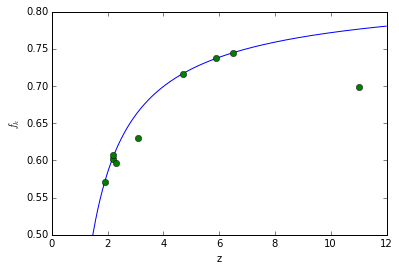

In [59]:
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
# 
#   Define a function that can calculate the f_k values
#   
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
objID = arrangeList(objID_ALL)
x_centroid = arrangeList(x_centroid_ALL)
y_centroid = arrangeList(y_centroid_ALL)
alphax = arrangeList(alphax_fk_ALL)
alphay = arrangeList(alphay_fk_ALL)
redshift = arrangeList(redshift_ALL)


def fk(thetax,thetay,ax,ay):
    ## thetax = [432,413,3421], thetay = [341,351,53], ax = [413,431,45321], ay = [41,4314,431]
    ## output f_k
    n_k = len(thetax)
    if len(thetax) != len(thetay) != len(ax) != len(ay):
        print('Input arrays have dimension problem')
    else:
        f = 0
        for i in range(len(thetax)):
            for j in range(len(thetay)):
                if i > j:
                    delta_thetax = thetax[i] - thetax[j]
                    delta_thetay = thetay[i] - thetay[j]
                    delta_alphax = ax[i] - ax[j]
                    delta_alphay = ay[i] - ay[j]
                    var = (delta_thetax * delta_alphax + delta_thetay * delta_alphay)/(delta_alphax ** 2 + delta_alphay **2)
                    f = f + var
                    print(var)
        f = 2/(n_k *(n_k - 1)) * f
        return f
fk_ALL = np.zeros(len(objID))
redshift_reduced = np.zeros(len(objID))

for k in range(len(objID)):
    fk_ALL[k] = fk(x_centroid[k],y_centroid[k],alphax[k],alphay[k])
    redshift_reduced[k] = redshift[k][0]

#fk_ALL is the y-axis, redshift_reduced is the x- axis

# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 
# 
#   Calculate the theoretical f_k curve
#   
# = * = * = * = * = * = * = * = * = * = * = * = * = * = * = * 

x = np.arange(0,12,0.01)
fk_model = map(DlsDs, x)

plt.plot(x, fk_model)
plt.plot(redshift_reduced, fk_ALL, 'o')
plt.axis([0, 12, 0.5, 0.8])
plt.xlabel('z')
plt.ylabel(r'$f_k$')
plt.figure(figsize=(30,25))
plt.show()

1.514102126
